Changelog
- 3 Oct
    - Creation
    - Add `Tables`, `DataValueInterfaces` and `DataAPI` because `PGFPlots` wasn't getting precompiled

In [97]:
using DelimitedFiles # To use readdlm
using PGFPlots
using StatsBase # To use mean

#### glass dataset

In [69]:
# function: make even bins
"""
    function make_bins(num_bins,lo,hi)
- Make `num_bins` even bins from `lo` to `hi`

# Example
```julia
bin_lefts = make_bins(10,0.29,3.50)
```
"""
function make_bins(num_bins,lo,hi;verbosity=false)
    bin_array = fill(0.,num_bins)
    if verbosity print("lo=$lo,hi=$hi,num_bins=$num_bins\n") end
    width = (hi-lo)/num_bins
    if verbosity print("width=$width\n") end
    for i in 1:num_bins
        bin_array[i] = lo+width*(i-1)
    end
    return bin_array
end

# function: Create dict with bins and corresponding average outputs
"""
    function binned_y_average(binned_y_train)
- Given a dict with bin number as keys and array of output values as value
- Return dict with same bin number keys but just the corresponding mean value

# Example
```julia
binavg_y_train = binned_y_average(binned_y_train)
```
"""
function binned_y_average(binned_y_train)
    binavg_y_train = Dict{Int64,Float64}()
    for (k,v) in binned_y_train
        binavg_y_train[k] = mean(v)
    end
    return binavg_y_train
end

make_bins

In [79]:
g = readdlm("glass.dat");y_train = Float64.(a[2:end,2]);x_train=Float64.(a[2:end,5]);

In [81]:
num_bins = 10;lo=0.29;hi=3.50;
bin_lefts = make_bins(num_bins,lo,hi);

binned_y_train = Dict{Int64,Array{Float64,1}}()
binned_x_train = Dict{Int64,Array{Float64,1}}()
# initialize the dictionary
for i in 1:num_bins
    binned_y_train[i] = []
    binned_x_train[i] = []
end
# Go over the training set and push the y values into bins to take mean later
for (j,x_train_sample) in enumerate(x_train)
    push!(binned_y_train[argmin(abs.(x_train_sample .- bin_lefts))],y_train[j])
    push!(binned_x_train[argmin(abs.(x_train_sample .- bin_lefts))],x_train_sample)
end
binned_x_train

Dict{Int64,Array{Float64,1}} with 10 entries:
  7  => [2.12, 2.08, 2.1, 2.17, 2.09, 2.22, 2.06, 2.34, 2.25, 2.27, 2.08]
  4  => [1.1, 1.36, 1.29, 1.24, 1.14, 1.37, 1.36, 1.27, 1.4, 1.27  …  1.35, 1.2…
  9  => [2.79, 2.74, 2.88]
  10 => [3.5, 3.04, 3.02]
  2  => [0.47, 0.47, 0.72, 0.71, 0.51, 0.66, 0.56, 0.77, 0.75, 0.67, 0.65, 0.58…
  3  => [1.05, 0.89, 0.79, 0.88, 0.78, 0.9, 0.87, 0.87, 0.9, 0.82, 1.06, 0.83, …
  5  => [1.54, 1.62, 1.56, 1.69, 1.49, 1.43, 1.52, 1.57, 1.54, 1.51  …  1.54, 1…
  8  => [2.38, 2.68, 2.54, 2.66, 2.51, 2.42]
  6  => [1.74, 1.9, 1.87, 1.88, 1.81, 1.79, 1.76, 1.86, 1.83, 1.76  …  1.79, 2.…
  1  => [0.29, 0.34]

In [95]:
binavg_y_train = binned_y_average(binned_y_train)

Dict{Int64,Float64} with 10 entries:
  7  => 0.861818
  4  => 0.199383
  9  => -1.71333
  10 => -4.16333
  2  => 4.96357
  3  => 3.54056
  5  => -0.551296
  8  => -2.405
  6  => -0.619545
  1  => -2.595

In [101]:
# Generate x_test and find corresponding y_test from binned y average
x_test = make_bins(200,lo,hi);
y_test = fill(0.,length(x_test),)
for (i,x_test_sample) in enumerate(x_test)
    y_test[i] = binavg_y_train[argmin(abs.(x_test_sample .- bin_lefts))]
end

In [103]:
plot_regressogram = PGFPlots.Plots.Scatter(x_test,y_test,legendentry="Regressogram");

In [105]:
plot_trainingdata = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="Train");

Sorting will be helpful for local averaging but we are doing it brute force because compute

In [108]:
# Local averaging
bin_width = (hi-lo)/num_bins
x_test = make_bins(200,lo,hi)
y_test_localavg = fill(0.,length(x_test),)
for (i,x_test_sample) in enumerate(x_test)
    x_neighbors = []
    y_neighbors = []
    for (kk,x_train_sample) in enumerate(x_train)
        if abs(x_train_sample-x_test_sample) <= bin_width
            push!(x_neighbors,x_train_sample)
            push!(y_neighbors,y_train[kk])
        end
    end
    y_test_localavg[i] = mean(y_neighbors)
end

In [110]:
plot_localavg = PGFPlots.Plots.Scatter(x_test,y_test_localavg,legendentry="Local Averaging");

In [130]:
# Gaussian Kernel
y_test_gaussian = fill(0.,length(x_test),)
for (i,x_test_sample) in enumerate(x_test)
    weights = fill(0.,length(x_train),)
    
    for (kk,x_train_sample) in enumerate(x_train)
        weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bin_width)^2)
    end
    y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
end

In [131]:
plot_gaussian = PGFPlots.Plots.Scatter(x_test,y_test_gaussian,legendentry="Gaussian Kernel");

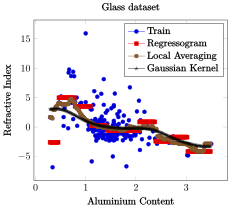

In [133]:
PGFPlots.Axis([plot_trainingdata,plot_regressogram,plot_localavg,plot_gaussian],
    xlabel="Aluminium Content",ylabel="Refractive Index",title="Glass dataset")

#### motorcycle dataset

In [31]:
m = readdlm("motor.dat"); y = Float64.(m[2:end,2]); x = Float64.(m[2:end,1]);

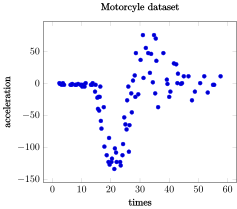

In [32]:
PGFPlots.Axis(PGFPlots.Plots.Scatter(x,y),xlabel="times",ylabel="acceleration",title="Motorcyle dataset")